In [496]:
%matplotlib inline

In [497]:
# I'm not telling you what to import this time - it's an exam! 
import numpy as np
import astropy as ap
import matplotlib.pyplot as plt
from astropy import units as u
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt
from scipy.optimize import curve_fit

### Ferdinand Ferdinand
### Even though you are submitting these with `git` and this file tells you to rename it, and you should be pushing to a dedicated folder with your username, please also stick your name in this file here, so there's extra redundancy. 

The point of this Midterm is to 
- cover material that we haven't had a chance to put on a homework yet
- throw in a curveball that will require you to actually understand the material you learned
- generally give me a sense of where you all are at the halfway point 

# Q1. Noise, Simulations and Fourier Transforms ( 40 pts)

You should probably begin by reading this short article on how to generate noise
https://paulbourke.net/fractals/noise/

Generate the following time streams: 
- 5.5 Hz signal
- "dirty" 60 Hz signal (hint: https://ep2000.com/what-is-dirty-electricity-and-how-to-remove-it-from-your-home/?v=e75edac1b83f - how you generate the noise is up to you - you can round the value of a sine wave for instance to the nearest something)
- white noise
- Brownian noise
- 1/f noise
- sum of all the above

8 points each:
a) Plot the time streams and make the plot pretty (I'm not being as specific as before because you ought to know by now).

b) Measure the standard deviation of each noise time stream. Count and report the number of time samples above (or below) 3 sigma.

c) Fourier Transform the time streams and plot the power spectral densities

d) Do a power law fit and measure the slope of the noise components. What is alpha (1/f^alpha) for the various components? (Report an error) Show your fits. (https://scipy-cookbook.readthedocs.io/items/FittingData.html) 

e) To the total timestream: (3 + 3 + 2)
- apply a high-pass filter
- apply a low-pass filter
- plot the power spectral density

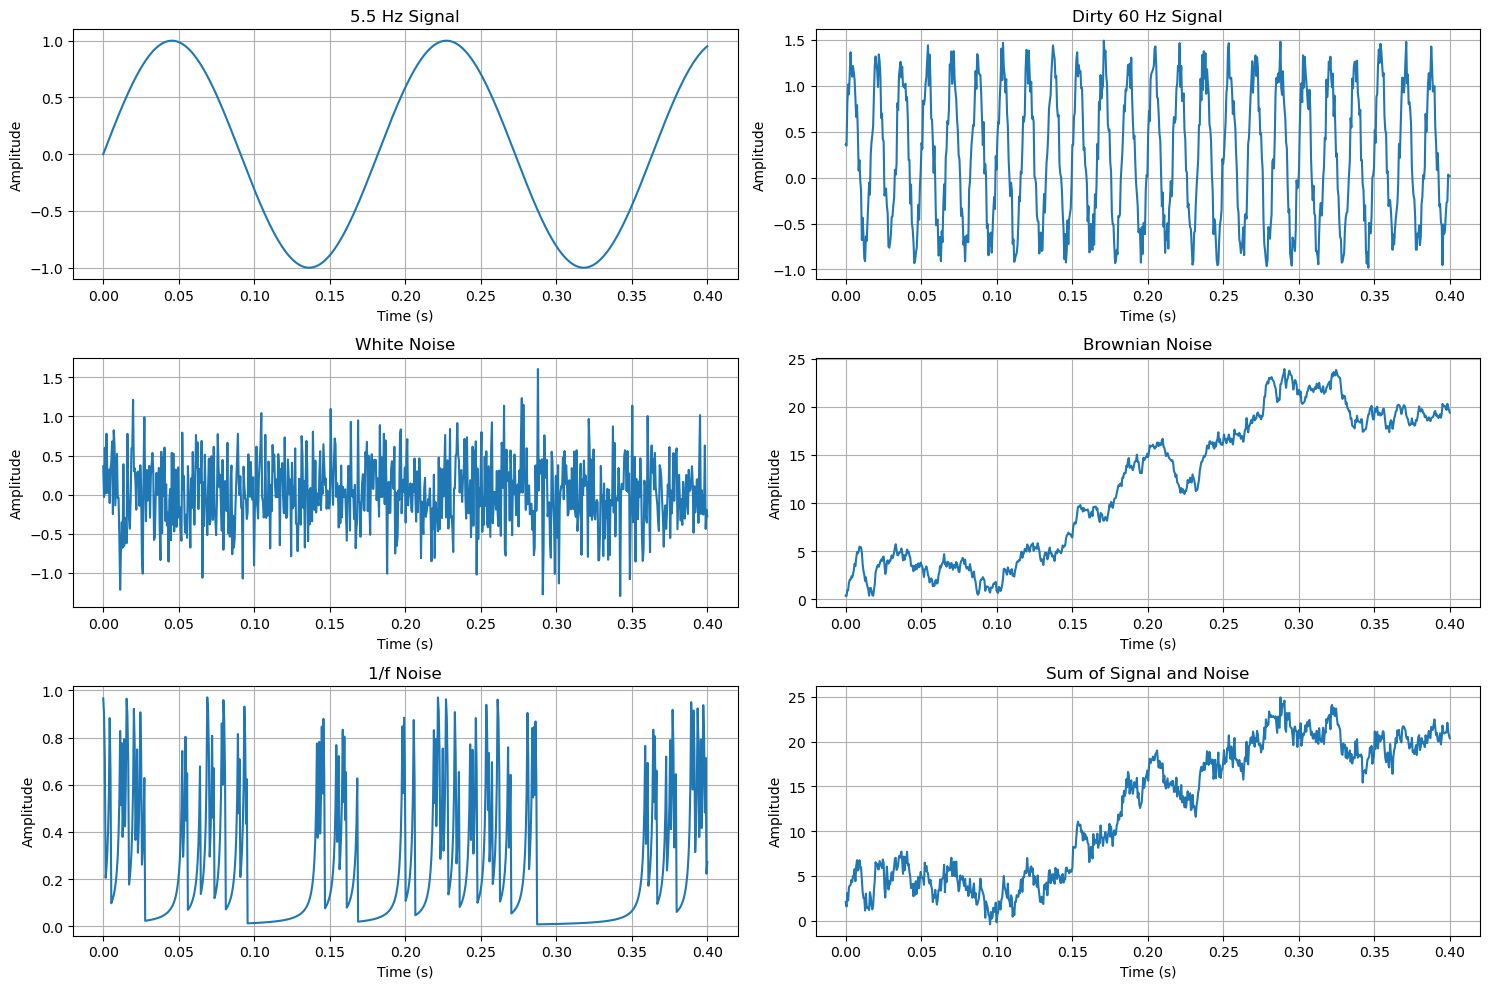

In [498]:
# For part a
rng = np.random.default_rng(seed=699)
# Initialize things...
N_samples = 750
end_time = 0.4
t_samples = np.linspace(0, end_time, N_samples)
def omega(f):
    return 2 * np.pi * f

signal_5_5Hz = np.sin(omega(5.5) * t_samples)

# Make a "dirty" signal with gaussian noise
clean_signal_60Hz = np.sin(omega(60) * t_samples)
gaussian_noise = rng.uniform(size=N_samples) * 0.5
dirty_signal_60Hz = clean_signal_60Hz + gaussian_noise

# White, brownian, 1/f noise
white_noise = rng.normal(0, end_time, N_samples)
brownian_noise = np.cumsum(white_noise)
one_over_f_noise = np.zeros(N_samples)
one_over_f_noise[0] = rng.random()
for i in range(1, N_samples):
    one_over_f_noise[i] = (one_over_f_noise[i-1] + one_over_f_noise[i-1]**2) % 1 
    
total_noise = signal_5_5Hz + dirty_signal_60Hz + white_noise + brownian_noise + one_over_f_noise

signals = [
    signal_5_5Hz,
    dirty_signal_60Hz,
    white_noise,
    brownian_noise,
    one_over_f_noise,
    total_noise
]

titles = [
    '5.5 Hz Signal',
    'Dirty 60 Hz Signal',
    'White Noise',
    'Brownian Noise',
    '1/f Noise',
    'Sum of Signal and Noise'
]

def plot_signals(time, signals, titles):
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))
    axs = axs.flatten()
    for i, signal in enumerate(signals):
        axs[i].plot(time, signal)
        axs[i].set_title(titles[i])
        axs[i].set_xlabel('Time (s)')
        axs[i].set_ylabel('Amplitude')
        axs[i].grid(True)
    plt.tight_layout()
    plt.show()
    
plot_signals(t_samples, signals, titles)

In [518]:
# Part b
signals_2 = [
    signal_5_5Hz,
    dirty_signal_60Hz,
    white_noise,
    brownian_noise,
    one_over_f_noise
]

titles_2 = [
    '5.5 Hz Signal',
    'Dirty 60 Hz Signal',
    'White Noise',
    'Brownian Noise',
    '1/f Noise'
]

def count_above_3sigma(noise, std):
    return np.sum(np.abs(noise) > 3 *std)
    # return np.sum((noise > np.mean(noise) + 3 * std) | (noise < np.mean(noise) - 3 * std))

noise_stds_above_3sigma = {
    "Clean 5.5 Hz Signal": [np.std(signal_5_5Hz), count_above_3sigma(signal_5_5Hz, np.std(signal_5_5Hz))], 
    "Dirty 60Hz Signal": [np.std(dirty_signal_60Hz), count_above_3sigma(dirty_signal_60Hz, np.std(dirty_signal_60Hz))],
    "White noise": [np.std(white_noise), count_above_3sigma(white_noise, np.std(white_noise))], 
    "Brownian noise": [np.std(brownian_noise), count_above_3sigma(brownian_noise, np.std(brownian_noise))], 
    "1/f noise": [np.std(one_over_f_noise), count_above_3sigma(one_over_f_noise, np.std(one_over_f_noise))]
}

for name, count in noise_stds_above_3sigma.items():
    print(f"{name} Standard Deviation: {count[0]:.4f}")
    print(f"Number of samples beyond 3σ: {count[1]}\n")

Clean 5.5 Hz Signal Standard Deviation: 0.6977
Number of samples beyond 3σ: 0

Dirty 60Hz Signal Standard Deviation: 0.7223
Number of samples beyond 3σ: 0

White noise Standard Deviation: 0.4314
Number of samples beyond 3σ: 2

Brownian noise Standard Deviation: 7.4251
Number of samples beyond 3σ: 46

1/f noise Standard Deviation: 0.2700
Number of samples beyond 3σ: 44



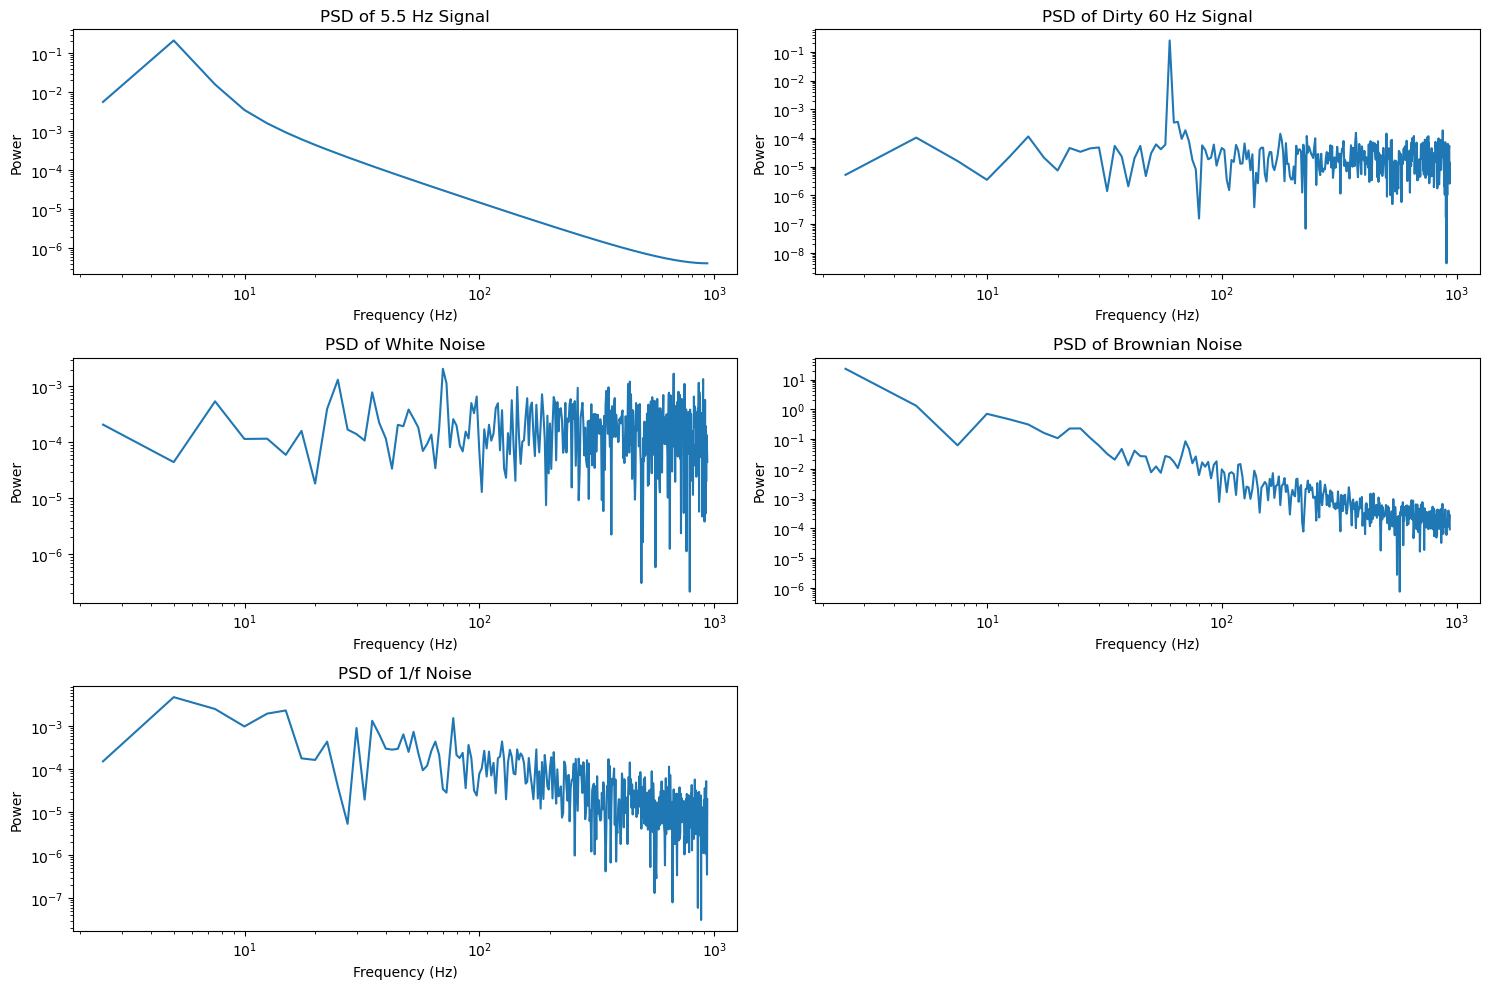

In [513]:
# Part c
def plot_psd_in_grid(signals, names):
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))
    axs = axs.flatten()
    for i, (signal, name) in enumerate(zip(signals, names)):
        N = len(signal)
        dt = t_samples[1] - t_samples[0]
        freqs = np.fft.fftfreq(N, d=dt)
        positive_freqs = freqs > 0
        freqs = freqs[positive_freqs]
        fft_vals = np.fft.fft(signal)[positive_freqs]
        psd = (np.abs(fft_vals) ** 2) / (N ** 2)
        
        axs[i].loglog(freqs, psd)
        axs[i].set_title(f'PSD of {name}')
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('Power')
    fig.delaxes(axs[5])
    plt.tight_layout()
    plt.show()
    
plot_psd_in_grid(signals_2, titles_2)

5.5 Hz Signal α (alpha): 1.87 ± 0.02



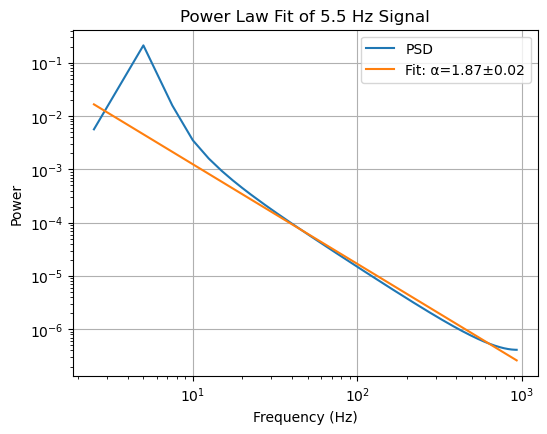

Dirty 60 Hz Signal α (alpha): 0.17 ± 0.07



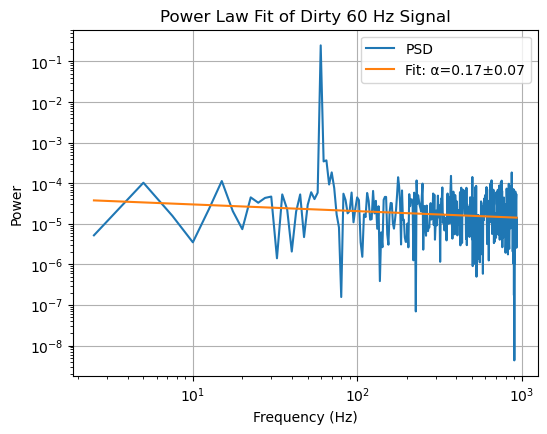

White Noise α (alpha): 0.11 ± 0.07



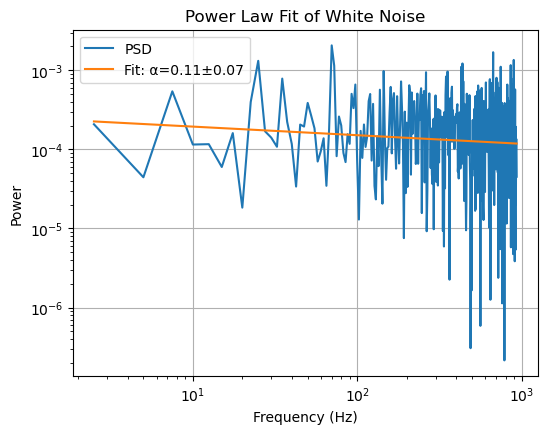

Brownian Noise α (alpha): 1.78 ± 0.05



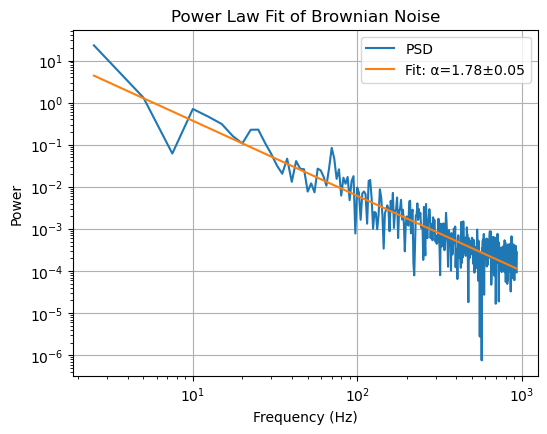

1/f Noise α (alpha): 1.19 ± 0.07



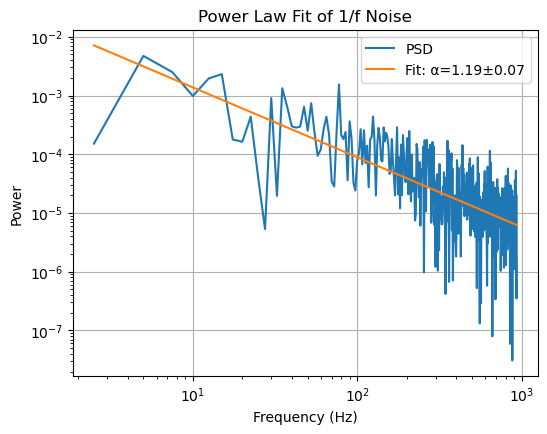

In [512]:
# Part d
def power_law_fit(signal, name):
    N = len(signal)
    dt = t_samples[1] - t_samples[0]
    freqs = np.fft.fftfreq(N, d=dt)
    positive_freqs = freqs > 0
    freqs = freqs[positive_freqs]
    fft_vals = np.fft.fft(signal)[positive_freqs]
    psd = (np.abs(fft_vals) ** 2) / (N**2)
    
    # Since the power law is in log-log scale, let's fit it using log y = a log x + b
    log_freqs = np.log10(freqs)
    log_psd = np.log10(psd)
    
    def linear_log(x, a, b):
        return a * x + b
    
    popt, pcov = curve_fit(linear_log, log_freqs, log_psd)
    # Since it's 1/f^alpha = f^(-alpha), we use negative sign in front of popt[0]
    alpha = -popt[0]
    alpha_err = np.sqrt(np.diag(pcov))[0]
    
    print(f"{name} α (alpha): {alpha:.2f} ± {alpha_err:.2f}\n")
    plt.figure(figsize=(6, 4.5))
    plt.loglog(freqs, psd, label='PSD')
    plt.loglog(freqs, 10**(linear_log(log_freqs, *popt)), label=f'Fit: α={alpha:.2f}±{alpha_err:.2f}')
    plt.title(f'Power Law Fit of {name}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.legend()
    plt.grid(True)
    plt.show()

for idx, signal in enumerate(signals_2):
    power_law_fit(signal, titles_2[idx])

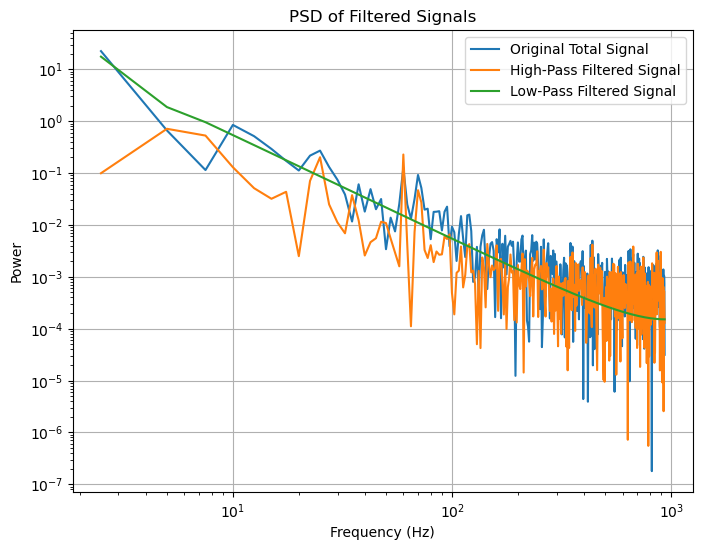

In [534]:
# Part e
def apply_filter(signal, cutoff_freq, fs, filter_type='low'):
    b, a = butter(N=5, Wn=cutoff_freq / (0.5 * fs), btype=filter_type)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Idk what to use, so I just put some random reasonable number I guess
fs = 10000
cutoff = 20
filtered_high = apply_filter(total_noise, cutoff, fs, 'high')
filtered_low = apply_filter(total_noise, cutoff, fs, 'low')

def plot_filtered_psd(signals, names):
    plt.figure(figsize=(8, 6))
    for signal, name in zip(signals, names):
        N = len(signal)
        dt = t_samples[1] - t_samples[0]
        freqs = np.fft.fftfreq(N, d=dt)
        positive_freqs = freqs > 0
        freqs = freqs[positive_freqs]
        fft_vals = np.fft.fft(signal)[positive_freqs]
        psd = (np.abs(fft_vals) ** 2) / (N**2)
        plt.loglog(freqs, psd, label=name)
    plt.title('PSD of Filtered Signals')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.legend()
    plt.grid(True)
    plt.show()

filtered_signals = [
    total_noise,
    filtered_high,
    filtered_low
]

filtered_names = [
    'Original Total Signal',
    'High-Pass Filtered Signal',
    'Low-Pass Filtered Signal'
]

plot_filtered_psd(filtered_signals, filtered_names)

# Q2 - Working with images and what that negative k-correction actually means for sources. (30 pts)

In your last homework assignment, you whined about calculating the k-correction for some sub-mm galaxy.

So lets give you a more visual picture of what the negative k-correction actually does.
First, download and install DS9: http://ds9.si.edu/site/Home.html (or using conda)

Next, download the .fits files here: 
https://www.dropbox.com/scl/fo/pdcu1svt369dr5kshuq79/ALqZX0apyaqhxKO-qdjy-vg?rlkey=5y2hyqmlgzpjvn96whd1w348f&dl=0 

These are optical g,r,i DES images, an SPT 220GHz image, and an ALMA 870um image. Use Python to read in the .fits images.

In each case below, print your answer clearly (6 pts a piece) 
- Calculate the standard deviation of the SPT and ALMA maps. This is the noise.
- Now calculate the maximum signal-to-noise ratio in each map.
- Make a 3-color image from DES in DS9 (hint: Frame —> New Frame RGB in ds9 or use trilogy: https://pypi.org/project/trilogy/)
- Overplot the SPT contours at 3,5,7,9 sigma (hint: Analysis—> Contour Parameters in ds9 or use scipy.stats)
- Overplot the ALMA contours at 5,10,15,20 sigma.

It should look something like this:
https://www.dropbox.com/scl/fi/bllp2l5293w4cb8eg5dyz/prob3_example.png


  


In [503]:
from astropy.io import fits
# from trilogy import 
ALMA_map_filepath = './midterm_data/SPT0538-50_ALMA_870um.fits'
SPT_map_filepath = './midterm_data/SPT0538-50_SPT_220GHz.fits'

def calculate_std_map(map_file):
    hdu_list = fits.open(map_file)
    image_data = hdu_list[0].data
    std_map = np.std(image_data)
    max_SNR = np.max(image_data)/std_map
    mean_map = np.mean(image_data)
    hdu_list.close()
    return std_map, max_SNR, mean_map, image_data

# Calculate std for SPT and ALMA -> noise 
# Calculate max SNR = max_data / noise
std_SPT, max_SNR_SPT, mean_SPT, SPT_img_data = calculate_std_map(SPT_map_filepath)
std_ALMA, max_SNR_ALMA, mean_ALMA, ALMA_img_data = calculate_std_map(ALMA_map_filepath)
std_SPT, max_SNR_SPT, std_ALMA, max_SNR_ALMA

(7.949267e-05, 8.572112, 0.0013849463, 18.99373)

In [504]:
from trilogy import trilogy
from PIL import Image
# Make a 3 color image from DES
DES_g = './midterm_data/DESJ053816.9-503050.8_g.fits'
DES_r = './midterm_data/DESJ053816.9-503050.8_r.fits'
DES_i = './midterm_data/DESJ053816.9-503050.8_i.fits'
# Create the RGB image using Trilogy
imagesRGB = {"R": [DES_i], "G": [DES_r], "B": [DES_g]}
noiselums = {'R': 0.5, 'G': 0.5, 'B': 0.5}
trilogy.Trilogy(infile = None, samplesize = 20000, stampsize = 20000, maxstampsize = 20000, \
                deletetests = 1, deletefilters = 1, testfirst = 0, showwith = "PIL", \
                mode = 'RGB', imagesorder = 'RGB', imagesRGB = imagesRGB, noiselums = noiselums, images = None, \
                outname = 'multiple_band_image', satpercent = 0.0009, noiselum = 0.5, noisesig = 50, \
                noisesig0 = 10, correctbias = 0, colorsatfac = 1, combine = 'sum', show = False).run()

From input file None :
From input parameters:
samplesize = 20000
stampsize = 20000
maxstampsize = 20000
deletetests = 1
deletefilters = 1
testfirst = 0
showwith = PIL
mode = RGB
imagesRGB = {'R': ['./midterm_data/DESJ053816.9-503050.8_i.fits'], 'G': ['./midterm_data/DESJ053816.9-503050.8_r.fits'], 'B': ['./midterm_data/DESJ053816.9-503050.8_g.fits']}
noiselums = {'R': 0.5, 'G': 0.5, 'B': 0.5}
outname = multiple_band_image
satpercent = 0.0009
noiselum = 0.5
noisesig = 50
noisesig0 = 10
correctbias = 0
colorsatfac = 1
combine = sum
show = False
invert = False
Default:
indir =  (default)
outdir =  (default)
thumbnail = None (default)
sampledx = 0 (default)
sampledy = 0 (default)
showstamps = 0 (default)
scaling = None (default)
legend = 0 (default)
noise = None (default)
saturate = None (default)
bscale = 1 (default)
bzero = 0 (default)
Loading image data.
If multiple filters per channel, adding data.
B
./midterm_data/DESJ053816.9-503050.8_g.fits[0] (1140, 1113) g
B = g

G
./midterm_data/

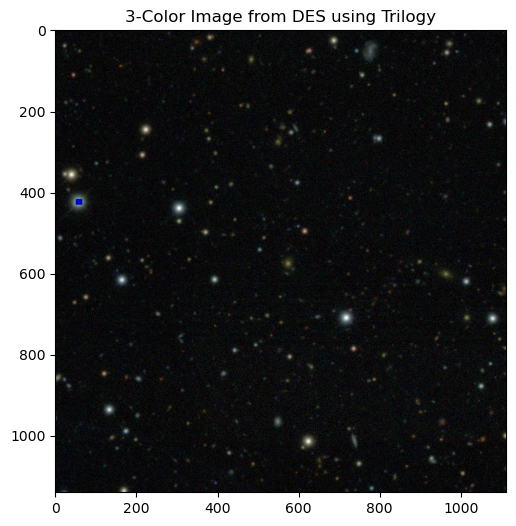

In [505]:
# I ended up failing contouring with Trilogy but I have made the image, so here we go
color_image_file = './multiple_band_image.png'
plt.figure(figsize=(8,6))
img = np.asarray(Image.open(color_image_file))
plt.imshow(img)
plt.title("3-Color Image from DES using Trilogy")
plt.show()

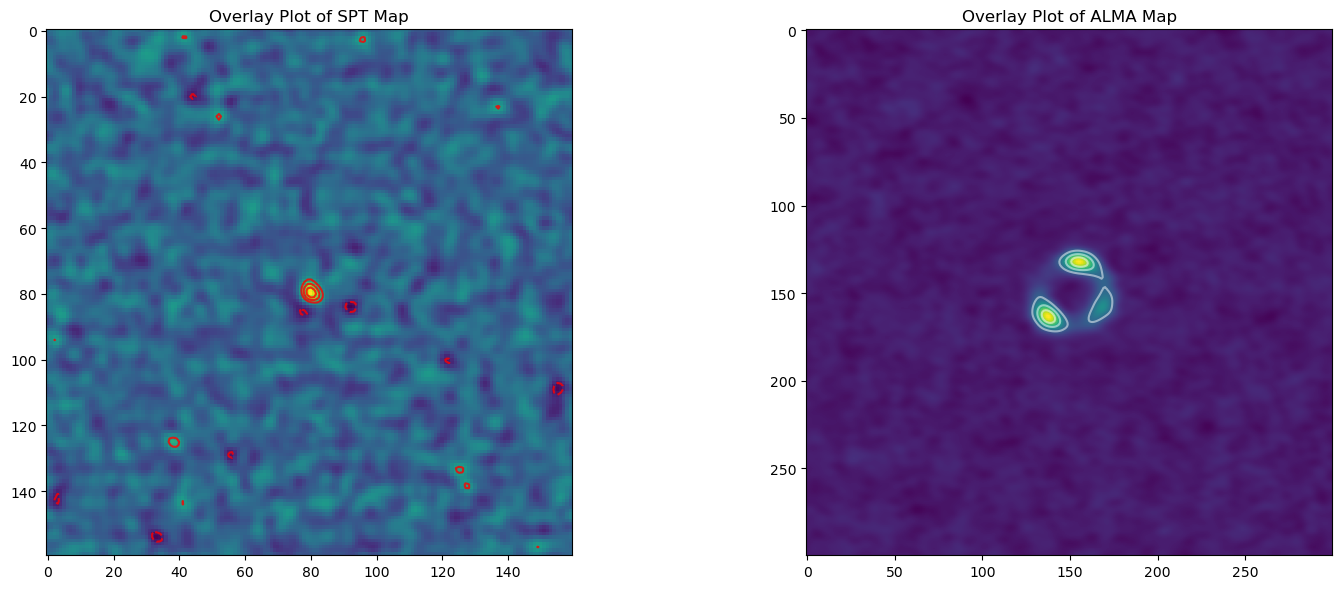

In [506]:
def sigma_contour_levels(sigma, levels, mean):
    contour_levels = []
    for level in levels:
        contour_levels.append(mean - level*sigma)
        contour_levels.append(mean + level*sigma)
    contour_levels = np.array(contour_levels)
    contour_levels.sort()
    return contour_levels

ALMA_contour_levels = sigma_contour_levels(std_ALMA, [5, 10, 15, 20], mean_ALMA)
SPT_contour_levels = sigma_contour_levels(std_SPT, [3, 5, 7, 9], mean_SPT)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].imshow(SPT_img_data)
axs[0].contour(SPT_img_data, levels=SPT_contour_levels, colors='red', alpha=0.8)
axs[0].set_title("Overlay Plot of SPT Map")
axs[1].imshow(np.squeeze(ALMA_img_data))
axs[1].contour(np.squeeze(ALMA_img_data), levels=ALMA_contour_levels, colors='white', alpha=0.5)
axs[1].set_title("Overlay Plot of ALMA Map")
plt.tight_layout()
plt.show()

In [507]:
def sigma_contour_levels(sigma, levels):
    contour_levels = []
    for level in levels:
        contour_levels.append(level*sigma)
    contour_levels = np.array(contour_levels)
    contour_levels.sort()
    return contour_levels

ALMA_contour_levels = sigma_contour_levels(std_ALMA, [5, 10, 15, 20])
SPT_contour_levels = sigma_contour_levels(std_SPT, [3, 5, 7, 9])
ALMA_contour_levels, SPT_contour_levels # For plotting over DS9

(array([0.00692473, 0.01384946, 0.02077419, 0.02769893]),
 array([0.00023848, 0.00039746, 0.00055645, 0.00071543]))

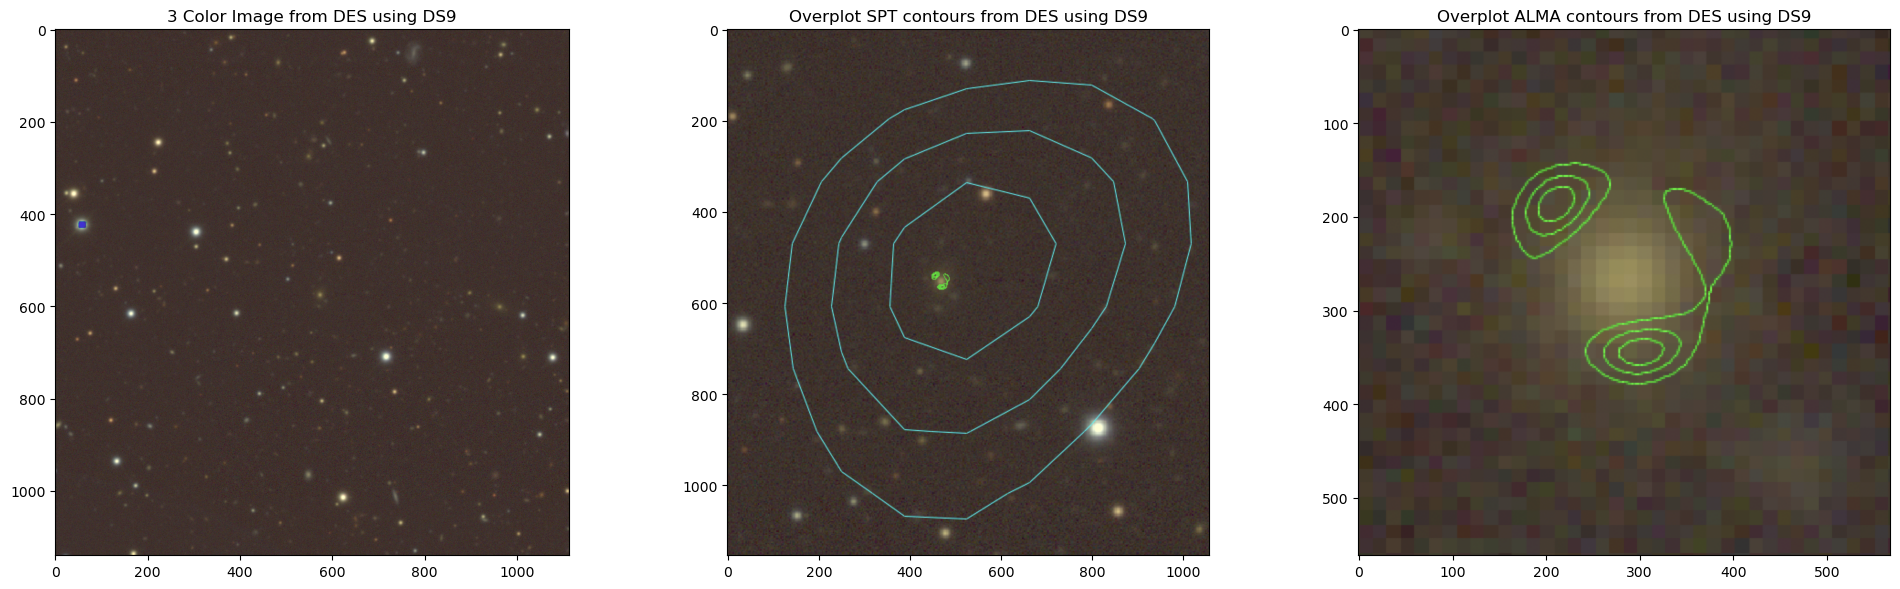

In [508]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
img0 = np.asarray(Image.open('./3_color_image.png'))
axs[0].imshow(img0)
axs[0].set_title("3 Color Image from DES using DS9")
img1 = np.asarray(Image.open('./Overplot_SPT.png'))
axs[1].imshow(img1)
axs[1].set_title("Overplot SPT contours from DES using DS9")
img2 = np.asarray(Image.open('./Overplot_ALMA.png'))
axs[2].imshow(img2)
axs[2].set_title("Overplot ALMA contours from DES using DS9")
plt.tight_layout()
plt.show()
# I know the background is a little yellow... but this is the best I can do :(

# Q3 - Coordinates, time conversions (30 pts) 

The star Vega (which you all know and love by now) has RA = 18h 36m 56s and Declination +38 deg 47' 01".

- Convert these coordinates
  a) decimal degrees
  b) into galactic coordinates

The University of Illinois observatory is at latitutde 40.112 degrees, while our longitude is -88.221 degrees.

- Use the expressions in the class slides to write a function that accepts arbitrary coordinates in RA and Dec and calculates the rise and set time of this source over the course of 2024.
  
- Plot the rise and set and set time of Vega for 2024
  

In [509]:
from astropy.coordinates import SkyCoord
from astropy import units as u

# Converting coordinates
ra = '18h36m56s'
dec = '+38d47m01s'
vega_coord = SkyCoord(ra, dec, frame='icrs')
vega_galactic_coord = vega_coord.galactic
print(f"Vega RA (deg): {vega_coord.ra.deg:.6f}, Vega Dec (deg): {vega_coord.dec.deg:.6f}")
print(f"Vega Galactic Longitude (l): {vega_galactic_coord.l.deg:.6f}, Vega Galactic Latitude (b): {vega_galactic_coord.b.deg:.6f}")

Vega RA (deg): 279.233333, Vega Dec (deg): 38.783611
Vega Galactic Longitude (l): 67.447738, Vega Galactic Latitude (b): 19.238254


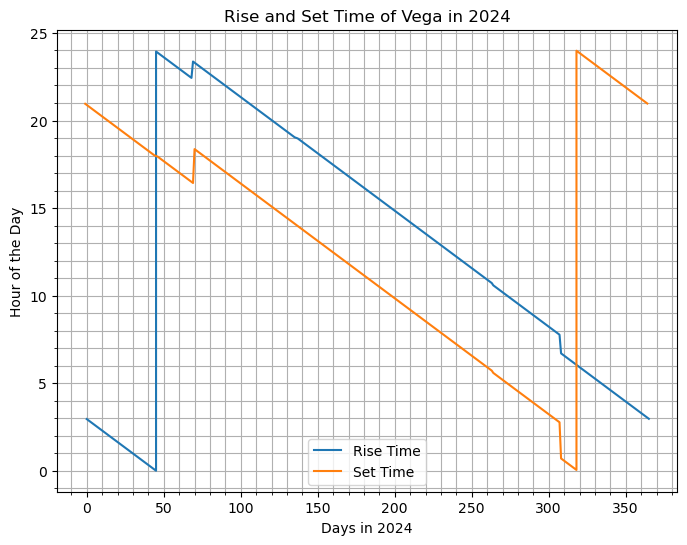

In [511]:
def rise_set(ra, dec):
    # UofI Observatory location:
    lat=40.112*u.deg
    lon=-88.221*u.deg
    # Finding hour angle when alt = 0
    H = 1/15 * (np.arccos(-np.tan(lat)*np.tan(dec))).to(u.deg) / u.deg * u.hour
    # Find LST, GST rise and set
    LSTrise = ((24 + ra.value/15 - H.value)) % 24
    LSTset = (ra.value/15 + H.value) % 24
    GSTrise = (LSTrise - lon.value/15.) % 24
    GSTset = (LSTset - lon.value/15.) % 24
    # Days in 2024 in JD
    JD = np.linspace(2460310.5, 2460675.5, 366)
    # Convert GST to UT
    def gst2ut(GST, JD):
        T  = (JD - 2451545.0) / 36525.0
        T0 = (6.697374558 + 2400.051336*T + 0.000025862*T**2) % 24.
        return 0.9972695663 * (GST - T0)
    # Find the UTC rise and set
    UTCrise = gst2ut(GSTrise, JD) % 24
    UTCset = gst2ut(GSTset, JD) % 24
    # Make it to a "coordinate" format kinda stuff to convert to CST or CDT
    time_rise = np.array([JD, UTCrise]).T
    time_set = np.array([JD, UTCset]).T
    # Convert to CST/CDT
    for i in range(366):
        # If it is CDT
        if time_rise[i, 0] >= 2460379.8333333335 and time_rise[i, 0] < 2460617.8333333335:
            temp_rise = time_rise[i, 1] - 5
            if temp_rise < 0:
                time_rise[i] = [time_rise[i, 0] - 1, temp_rise + 24]
            else:
                time_rise[i] = [time_rise[i, 0], temp_rise]
            temp_set = time_rise[i, 1] - 5
            if temp_set < 0:
                time_set[i] = [time_set[i, 0] - 1, temp_set + 24]
            else:
                time_set[i] = [time_set[i, 0], temp_set]
        else:
            temp_rise = time_rise[i, 1] - 6
            if temp_rise < 0:
                time_rise[i] = [time_rise[i, 0] - 1, temp_rise + 24]
            else:
                time_rise[i] = [time_rise[i, 0], temp_rise]
            temp_set = time_rise[i, 1] - 6
            if temp_set < 0:
                time_set[i] = [time_set[i, 0] - 1, temp_set + 24]
            else:
                time_set[i] = [time_set[i, 0], temp_set]
    return time_rise, time_set

    
# JD = np.linspace(2460310.5, 2460675.5, 366) 
time_rise, time_set = rise_set(vega_coord.ra, vega_coord.dec)
plt.figure(figsize=(8, 6))
plt.plot(time_rise[:, 0] - 2460310.5, time_rise[:, 1], label="Rise Time")
plt.plot(time_set[:, 0] - 2460310.5, time_set[:, 1], label="Set Time")
plt.xlabel("Days in 2024")
plt.ylabel("Hour of the Day")
plt.title("Rise and Set Time of Vega in 2024")
plt.minorticks_on()
plt.grid(True, which='both')
plt.legend()
plt.show()

### Divide and conquer, so you encounter issues in parallel and can explain things to each other, rather than working in series. 

# Due Oct 22 at Noon!